In [2]:
import cv2
import numpy as np

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

import albumentations as A

import os
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
IMG_PATH = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input'
MASK_PATH = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE= 32
SIZE = 256
LEARNING_RATE = 0.0003
NUM_EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True

### UNet Model

In [6]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Contracting path (encoder)
        self.conv1 = nn.Conv2d(self.n_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expansive path (decoder)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        # Contracting path (encoder)
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(self.pool(x1)))
        x3 = F.relu(self.conv3(self.pool(x2)))
        x4 = F.relu(self.conv4(self.pool(x3)))
        x5 = F.relu(self.conv5(self.pool(x4)))

        # Expansive path (decoder)
        x6 = F.relu(self.upconv1(x5))
        x6 = torch.cat([x4, x6], dim=1)
        x6 = F.relu(self.conv6(x6))
        x7 = F.relu(self.upconv2(x6))
        x7 = torch.cat([x3, x7], dim=1)
        x7 = F.relu(self.conv7(x7))
        x8 = F.relu(self.upconv3(x7))
        x8 = torch.cat([x2, x8], dim=1)
        x8 = F.relu(self.conv8(x8))
        x9 = F.relu(self.upconv4(x8))
        x9 = torch.cat([x1, x9], dim=1)
        x9 = F.relu(self.conv9(x9))
        x10 = self.conv10(x9)

        return x10

### Loading Dataset

In [7]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.ids = [image_file[:-4] for image_file in os.listdir(images_path) if image_file.endswith('.jpg')]
        self.size = size

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_path, self.ids[idx] + '.jpg')
        mask_path = os.path.join(self.masks_path, self.ids[idx] + '_segmentation.png')
        
        # Load image and mask
        img = cv2.imread(os.path.join(self.images_path, self.ids[idx] + '.jpg'), cv2.IMREAD_COLOR)
        mask = cv2.imread(os.path.join(self.masks_path, self.ids[idx] + '_segmentation.png'), cv2.IMREAD_GRAYSCALE)
        
         # Convert to RGB, And convert mask to binary
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ret, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations['image']
            mask = augmentations['mask']
        
        # Convert numpy arrays to PyTorch tensors
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        mask[mask == 255.0] = 1.0

        return img, mask

### Data Augmentation

In [8]:
transform = A.Compose(
[
    A.Resize(height=SIZE, width=SIZE),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1)
])

dataset = ISICDataset(images_path=IMG_PATH,
                            masks_path=MASK_PATH, size=SIZE, transform=transform)

train_size = int(0.8 * len(dataset))
train_dataset = Subset(dataset, range(train_size))
test_dataset = Subset(dataset, range(train_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Sample Image and Mask

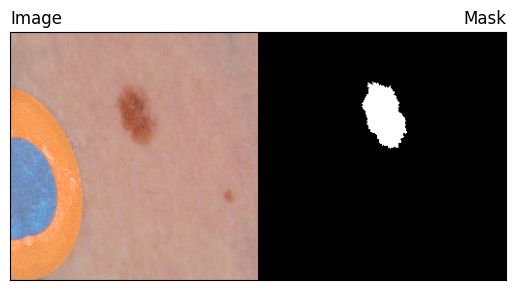

In [7]:
img, mask = test_dataset[18]
img = img.permute(1, 2, 0).numpy()
mask = mask.permute(1, 2, 0).squeeze().numpy()
mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
mask = np.expand_dims(mask, axis=2)
mask = np.repeat(mask, 3, axis=2)
concatenated_img = np.concatenate((img, mask), axis=1)

fig, ax = plt.subplots()
ax.imshow(concatenated_img)
ax.set_title('Image', loc='left')
ax.set_title('Mask', loc='right')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

### Defining Model

In [9]:
model = UNet(n_channels=3, n_classes=1).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_30/105582579.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


### Function for model accuracy

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    dice_score = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            dice_score += (2 * (preds * y).sum()) / (preds + y).sum() + 1e-8
            
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

### Training

In [ ]:
for epoch in range(30): 
    
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    
    if epoch % 5 == 0 and epoch != 0:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                      'epoch': epoch}
        torch.save(checkpoint, "checkpointN"+str(epoch)+"_.pth.tar")  
    
    
    for batch_idx, (images, masks) in loop:
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        # Gradients to 0
        optimizer.zero_grad()

        # Forward 
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)
        
        # Backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_description(f"Epoch[{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss = loss.item())


checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(checkpoint, "checkpoint_last.pth.tar")

### Loading pretrained model

In [10]:
model.load_state_dict(torch.load('/kaggle/input/pretrained_model/pytorch/default/1/checkpoint_last.pth.tar')['state_dict'])

/tmp/ipykernel_30/4132742247.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/pretrained_model/pytorch/default/1/checkpoin

<All keys matched successfully>

### Model Accuracy

In [ ]:
check_accuracy(test_loader, model, DEVICE)

### Validation

In [20]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Paths for validation images and masks
validation_path = "/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Validation_Input/"
val_img = sorted(glob.glob(validation_path + "/*.jpg"))
mask_path = r"/kaggle/input/isic2018-validation-ground-truth/ISIC2018_Task1_Validation_GroundTruth"
val_mask = sorted(glob.glob(mask_path + "/*.png"))

val_dataset = ISICDataset(images_path=validation_path,
                            masks_path=mask_path, size=SIZE, transform=transform)

### Display validation images

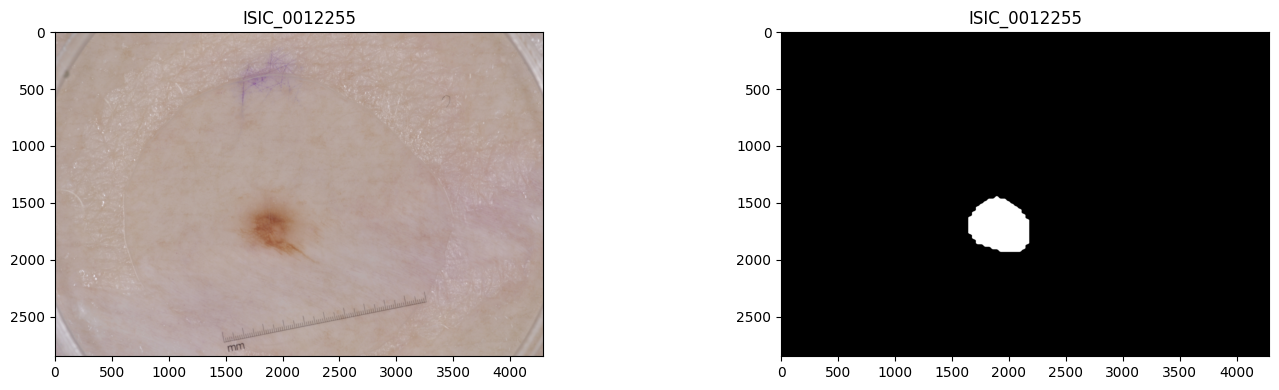

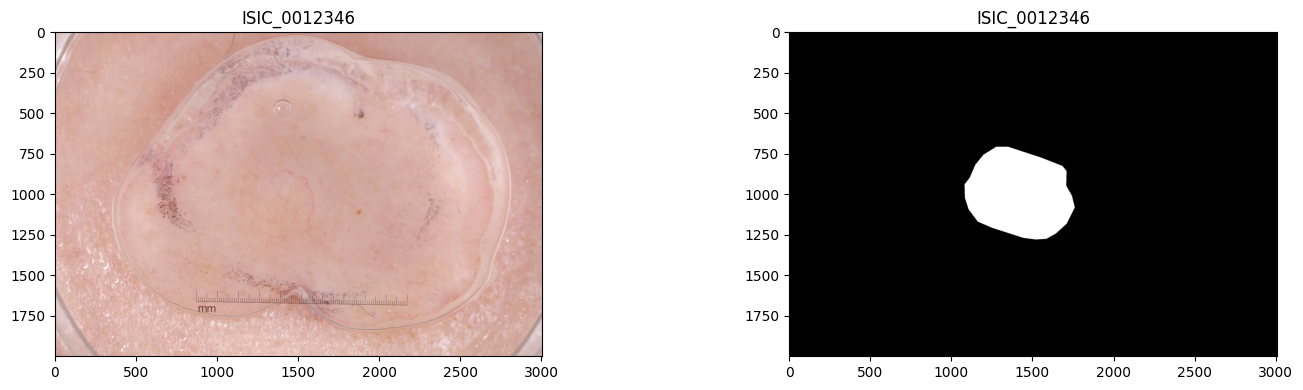

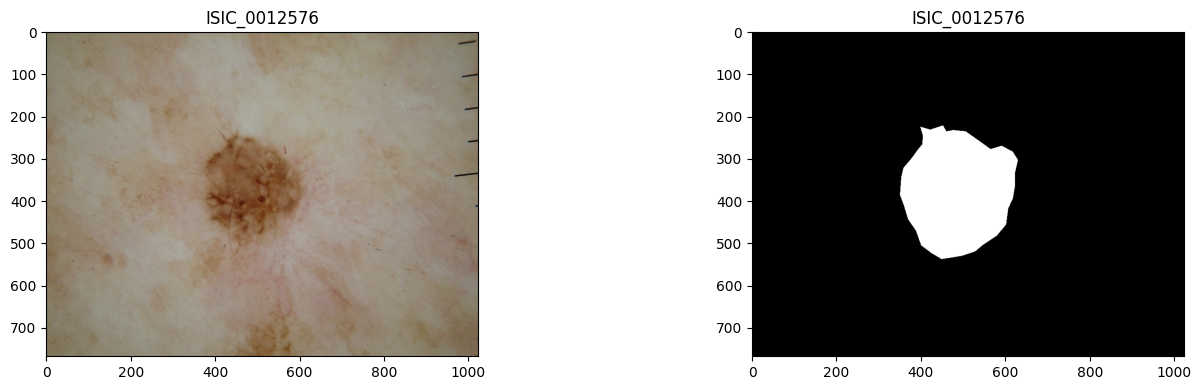

In [22]:
for i in range(3):
    samImg = cv2.imread(val_img[i])
    samMask = cv2.imread(val_mask[i])
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.title(val_img[i].split('/')[-1].rstrip(".jpg"))
    plt.imshow(cv2.cvtColor(samImg,cv2.COLOR_BGR2RGB))
    
    plt.subplot(1,2,2)
    plt.title(val_mask[i].split('/')[-1].rstrip("_segmentation.png"))
    plt.imshow(samMask)
    plt.tight_layout()
    plt.show()

In [23]:
# Define the transformation (resize, normalization) if needed
def preprocess_image(image_path, size, device):
    # Load image with OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB if needed

    # Resize the image if needed
    img_resized = cv2.resize(img, (size, size))

    # Convert image to float and normalize (assuming the model expects 0-1 range)
    img_resized = img_resized / 255.0

    # Convert to torch tensor and move to the specified device
    img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().to(device)
    
    return img_tensor

### Compute the metrics

In [24]:
# Initialize lists for storing metrics
imgId, dice_scores, iou_scores, sensitivities, specificities = [], [], [], [], []

# Loop through validation images and evaluate each one
for i in range(len(val_img)):
    # Preprocess the image
    img_tensor = preprocess_image(val_img[i], SIZE, DEVICE)
    
    with torch.no_grad():
        # Get predicted mask
        generated_mask = model(img_tensor).squeeze().cpu().numpy()  # Remove batch dimension and convert to numpy
    
    # Load and resize true mask for comparison
    true_mask = cv2.imread(val_mask[i], cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (generated_mask.shape[1], generated_mask.shape[0]))

    # Binarize masks for metric calculations
    threshold = 0.5
    true_mask_bin = (true_mask_resized > threshold).astype(np.uint8)
    generated_mask_bin = (generated_mask > threshold).astype(np.uint8)

    # Calculate metrics (Dice, IoU, Sensitivity, Specificity)
    intersection = np.sum(true_mask_bin * generated_mask_bin)
    dice_score = (2 * intersection) / (np.sum(true_mask_bin) + np.sum(generated_mask_bin))
    dice_scores.append(dice_score)
    
    union = np.sum(true_mask_bin) + np.sum(generated_mask_bin) - intersection
    iou = intersection / union if union != 0 else 0
    iou_scores.append(iou)
    
    true_positive = np.sum((true_mask_bin == 1) & (generated_mask_bin == 1))
    false_negative = np.sum((true_mask_bin == 1) & (generated_mask_bin == 0))
    sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) != 0 else 0
    sensitivities.append(sensitivity)
    
    true_negative = np.sum((true_mask_bin == 0) & (generated_mask_bin == 0))
    false_positive = np.sum((true_mask_bin == 0) & (generated_mask_bin == 1))
    specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) != 0 else 0
    specificities.append(specificity)
    
    # Store image id and scores
    imgId.append(val_img[i].split('/')[-1].rstrip(".jpg"))

### Store the metrics

In [26]:
# Compile results into a DataFrame
df = pd.DataFrame({
    "img_id": imgId,
    "dice_score": dice_scores,
    "jaccard_index": iou_scores,
    "sensitivity": sensitivities,
    "specificity": specificities
})

# Save results to Excel
df.to_excel("result_analysis.xlsx")

### Plot dice score for validation data

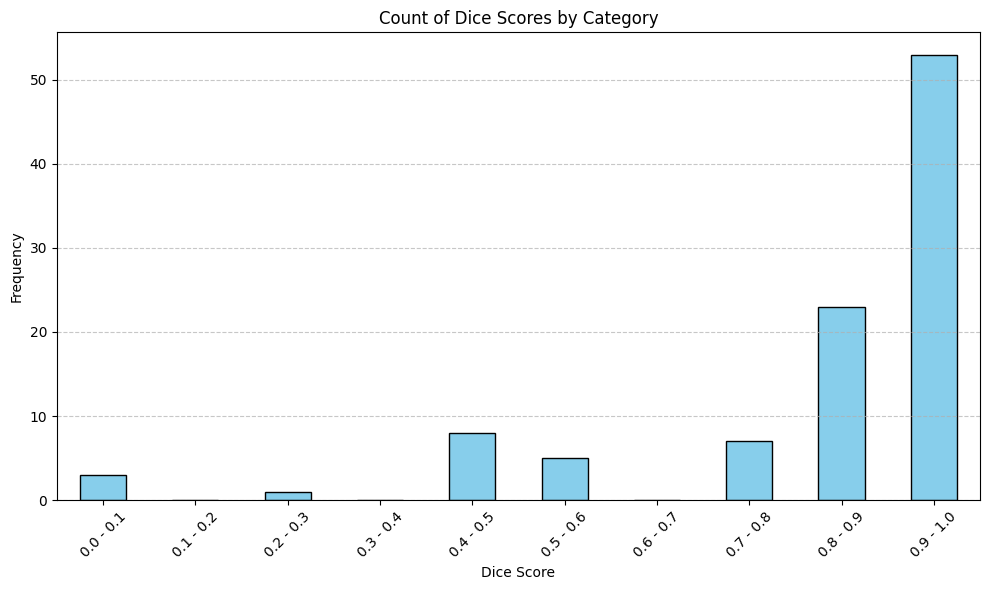

In [27]:
# Plot Dice Score Distribution
bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0.0 - 0.1', '0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4',
          '0.4 - 0.5', '0.5 - 0.6', '0.6 - 0.7', '0.7 - 0.8',
          '0.8 - 0.9', '0.9 - 1.0']

df['Category'] = pd.cut(df['dice_score'].round(2), bins=bins, labels=labels, right=False)
category_counts = df['Category'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of Dice Scores by Category')
plt.xlabel('Dice Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Manual Analysis

In [28]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def manual_check(ind):
    # Load the image path and true mask path based on the index
    img_path = val_img[ind]
    mask_path = val_mask[ind]
    
    # Load and preprocess the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_resized = cv2.resize(img, (SIZE, SIZE)) / 255.0  # Resize and normalize to 0-1
    
    # Load the true mask
    true_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    true_mask_resized = cv2.resize(true_mask, (SIZE, SIZE))
    
    # Convert image to tensor and move to the device
    img_tensor = torch.tensor(img_resized).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE)
    
    # Generate the mask with the model
    with torch.no_grad():
        generated_mask = model(img_tensor).squeeze().cpu().numpy()

    # Resize generated mask back to original image size for visualization
    generated_mask_resized = cv2.resize(generated_mask, (img.shape[1], img.shape[0]))
    true_mask_resized = cv2.resize(true_mask, (img.shape[1], img.shape[0]))

    # Stack the masks for visualization
    true_mask_stacked = np.stack((true_mask_resized,) * 3, axis=-1)
    generated_mask_stacked = np.stack((generated_mask_resized,) * 3, axis=-1)

    # Plot original image, true mask, and generated mask
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img)
    ax[0].set_title('Original Image')

    ax[1].imshow(true_mask_stacked, cmap='gray')
    ax[1].set_title('True Mask')

    ax[2].imshow(generated_mask_stacked, cmap='gray')
    ax[2].set_title('Generated Mask')

    plt.show()

    # Calculate Dice Score
    threshold = 0.5
    true_mask_bin = (true_mask_resized > threshold).astype(np.uint8)
    generated_mask_bin = (generated_mask_resized > threshold).astype(np.uint8)

    intersection = np.sum(true_mask_bin * generated_mask_bin)
    dice_score = (2 * intersection) / (np.sum(true_mask_bin) + np.sum(generated_mask_bin))

    # Output image ID and Dice Score
    img_id = img_path.split('/')[-1].rstrip(".jpg")
    print(f'Image ID: {img_id}')
    print(f'Dice Score: {dice_score:.4f}')

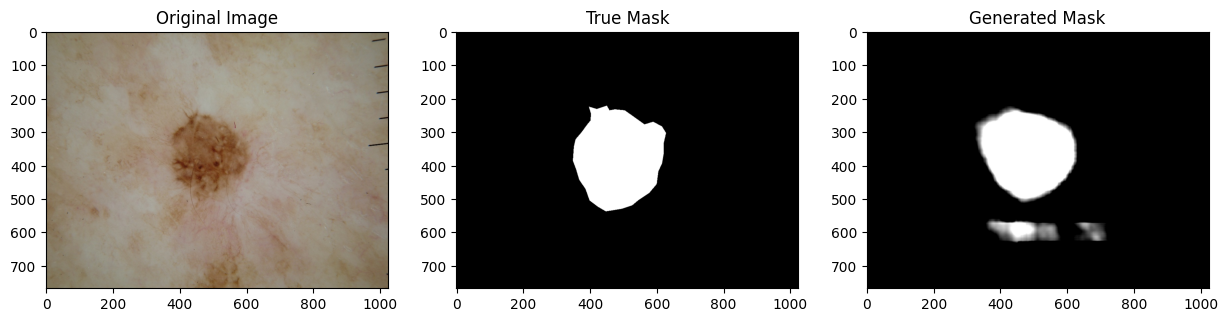

Image ID: ISIC_0012576
Dice Score: 0.8383


In [30]:
# Provide the image index here
manual_check(2)